Chaining: Chaining Lens Light To Mass
=====================================

Before reading this example, make sure you have read the `autolens_workspace/examples/moodel/chaining/api.py`
example script, which describes phase chaining and details the API for this.

In this example, we chain two phases, where:

 - The first phase models the lens galaxy's light using a bulge and disk, using `EllipticalSersic` and 
      `EllipticalExponential` profiles. The source is present in the image, but modeling it is omitted.
      
 - The second phase models the lens galaxy's mass distribution is fitted with the `EllipticalSersic` of the 
 `LightProfile`, where it is converted to a stellar mass distribution via a constant mass-to-light ratio. The lens 
 light model uses prior initialized from the result of phase 1.

The idea behind this phase is that for many strong lenses the lens galaxy's light is distinct from the source galaxy's
light. This makes it a valid approach to subtract the lens's light in a first step and then focus-in on fitting
the lens mass model and source's light.

There are a number of benefits to using phase chaining to model the lens's light and its mass and the source separately:

 - The non-linear parameter space defined by a bulge-disk (N=11), stellar and dark mass model (N=5) and parametric 
   Sersic source (N=7) has N=27 dimensions. By splitting the model-fit into two phases, we fit parameter spaces of
   dimensions N=11 and then N=27 with many priors initialized. These are more efficient to sample and pose less risk 
   of us inferring a local maxima or unphysical solution.

 - The lens galaxy's light traces the majority of its mass. Thus, we can use the lens light model inferred in phase 
   1 to place priors initializing the light mass model in phase 2.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


As per usual, load the `Imaging` data, create the `Mask2D` and plot them. In this strong lensing dataset:

 - The lens galaxy's `LightProfile` is a bulge+disk `EllipticalSersic` and `EllipticalExponential`.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalExponential`.

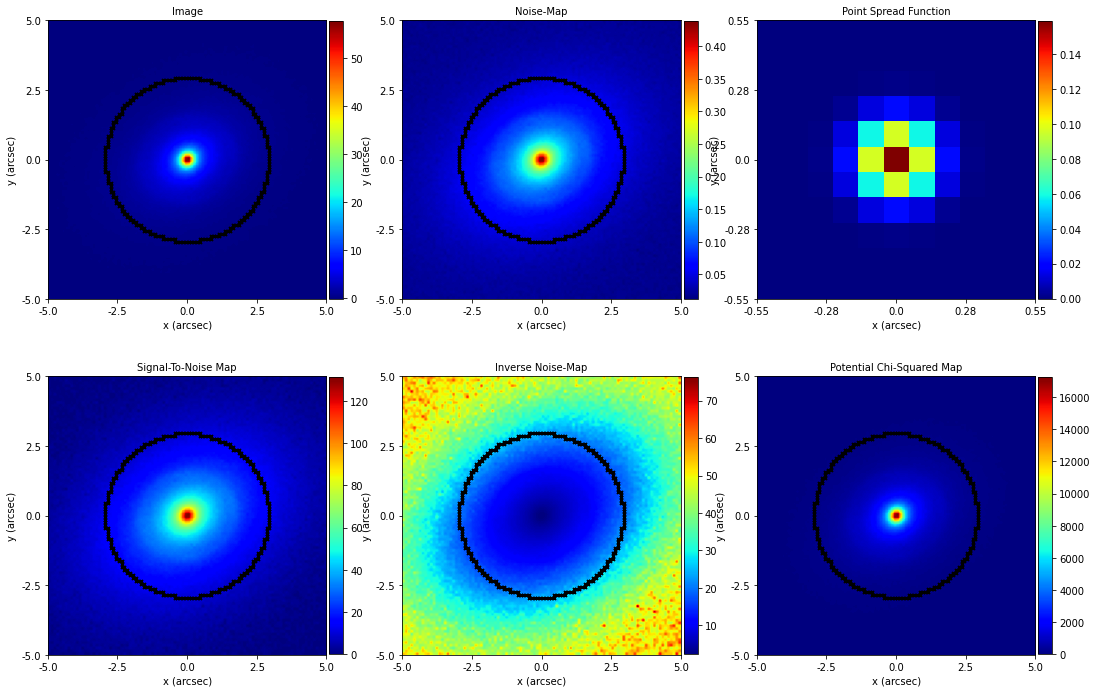

In [2]:
dataset_name = "light_sersic_exp__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens mooel is:

 - The lens galaxy's light is modeled parametrically as an `EllipticalSersic` and `EllipticalExponential` whose 
   centres are aligned (11 parameters).
 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal` and `ExternalShear` (7 parameters).
 - The source galaxy's light is modeled parametrically as an `EllipticalSersic` (7 parameters).

We are fitting on the lens's light in phase 1 and only its mass and the source in phase 2, giving us non-linear
parameter spaces of N=13 and N=12 respectively.

In [3]:
bulge = af.PriorModel(al.lp.EllipticalSersic)
disk = af.PriorModel(al.lp.EllipticalExponential)

bulge.centre = disk.centre

lens = al.GalaxyModel(redshift=0.5, bulge=bulge, disk=disk)

__Settings__

You should be familiar with the `SettingsPhaseImaging` object from other example scripts, if not checkout the beginner
examples and `autolens_workspace/notebooks/imaging/modeling/customize/settings.py`

In [4]:
settings_lens = al.SettingsLens(
    auto_positions_factor=3.0, auto_positions_minimum_threshold=0.2
)

settings = al.SettingsPhaseImaging(settings_lens=settings_lens)

__Search__

You should be familiar with non-linear searches from other example scripts if not checkout the beginner examples
and `autolens_workspace/notebooks/imaging/modeling/customize/non_linear_searches.py`.

In this example, we omit the PriorPasser and will instead use the default values used to pass priors in the config 
file `autolens_workspace/config/non_linear/nest/DynestyStatic.ini`

In [5]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", "chaining", "lens_light_to_light_dark_mass"),
    name="phase[1]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/examples/chaining/lens_light_to_light_dark_mass/light_sersic_exp__mass_sie__source_sersic/phase[1]`.

In [6]:
phase1 = al.PhaseImaging(
    search=search, settings=settings, galaxies=af.CollectionPriorModel(lens=lens)
)

phase1_result = phase1.run(dataset=imaging, mask=mask)

INFO:root:phase[1] already completed, skipping non-linear search.


Before reading on to phase 2, you may wish to inspect the results of the phase 1 model-fit to ensure the fast
non-linear search has provided a reasonably accurate lens light model.

__Model Chaining__

We use the results of phase 1 to create the lens light model in phase 2. 

This is passed as a `instance` (as opposed to a `model`, which was used in the API tutorial). By passing the lens 
light as an `instance` it passes the maximum log likelihood parameters of the fit in phase 1 as fixed values that are 
not free parameters fitted for by the `NonLinearSearch` in phase1.

We also use the inferred centre of the lens light model in phase 1 to initialize the priors on the lens mass model 
in phase 2. This uses the term `model` to pass priors, as we saw in other examples.

In [7]:
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.instance)

disk = af.PriorModel(al.lmp.EllipticalSersic)
disk.take_attributes(source=phase1_result.instance)

lens = al.GalaxyModel(
    redshift=0.5,
    bulge=phase1_result.instance.galaxies.lens.bulge,
    disk=phase1_result.instance.galaxies.lens.disk,
    dark=af.PriorModel(al.mp.SphericalNFW),
)
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic)

__Search__

In phase 2, we use the nested sampling algorithm `Dynesty` again.

In [8]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", "chaining", "lens_light_to_light_dark_mass"),
    name="phase[2]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/examples/chaining/lens_light_to_light_dark_mass/light_sersic_exp__mass_sie__source_sersic/phase[2]`.

Note how the `lens` passed to this phase was set up above using the results of phase 1!

In [9]:
phase2 = al.PhaseImaging(
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    search=search,
)

phase2.run(dataset=imaging, mask=mask)

INFO:root:phase[2] already completed, skipping non-linear search.


__Wrap Up__

In this example, we passed the bulge + disk lens light as an `instance`, as opposed to a `model`, meaning its 
parameters were fixed to the maximum log likelihood model in phase 1 and not fitted as free parameters in phase 2.

Of course, one could easily edit this script to fit the bulge + disk lens's light model in phase 2, using the
results of phase 1 to initialize the priors, by simply swapping out the `instance` for a `model` when setting up
the lens's `GalaxyModel`, as follows:

    lens = al.GalaxyModel(
        redshift=0.5,
        bulge=phase1.result.model.galaxies.lens.bulge,
        disk=phase1.result.model.galaxies.lens.disk,
        mass=mass,
    )

As discussed in the introduction, the benefit of passing the lens's light as an instance is that it reduces the 
dimensionality of the non-linear parameter space in phase 2. 

On the other hand, the lens light model inferred in phase 1 may not be perfect. The source light will impact the
quality of the fit which may lead to a sub-optimal fit. Thus, it may be better to pass the lens's light as a `model`
in phase 2. The model-fit will take longer to perform, but we'll still benefit from prior passing initializing the
samples of the `NonLinearSearch` in phase 2!

At the end of the day, it really comes down to you science case and the nature of your data whether you should pass the
lens light as an `instance` or `model`!

__Pipelines__

The next level of PyAutoLens uses `Pipelines`, which chain together multiple phases to perform very complex lens 
modeling in robust and efficient ways. Pipelines which fit the lens's light, for example:

 `autolens_wokspace/pipelines/with_lens_light/light_parametric__mass_total__source_parametric.py`

Exploit our ability to model separately the lens's light and its mass / the source to perform model-fits in non-linear
parameter spaces of reduced complex, to ensure more efficient and robust model-fits!